In [1]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

from tensorflow.keras.models import load_model
import pickle
from utility import *

2023-10-04 17:01:30.045189: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-04 17:01:30.948355: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-04 17:01:30.953418: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-04 17:01:33.903079: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/marc/spam_detection/.env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('SMSSpamCollection.csv' , sep='\t',names=["cat","sms"])

In [3]:
X = df['sms']
y = df['cat']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.75, random_state = 42, stratify = y)

In [4]:
X_test_mlp = np.load("X_test_mlp.npy", allow_pickle=True)
X_test_tf = np.load("X_test_tf.npy", allow_pickle=True)

In [5]:
tf_model = tf_model = load_model('modeleV1.h5')

with open('mlp.pkl', 'rb') as file:
        mlp_model = pickle.load(file)
        
with open('nb.pkl', 'rb') as file:
        nb_model = pickle.load(file)

In [6]:
tokenizer = BertTokenizer.from_pretrained('Tiny_Bert_token')
bert1_model = BertForSequenceClassification.from_pretrained('Tiny_Bert_model', num_labels=2)

X_test_bert1 = tokenizer(X_test.tolist(), padding=True, truncation=True, return_tensors='pt')

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [14]:
bert1_model.eval()
with torch.no_grad():
    outputs = bert1_model(**X_test_bert1)
    logits = outputs.logits
    predicted_labels = torch.argmax(logits, dim=1).cpu().numpy()
    probs = torch.nn.functional.softmax(logits, dim=-1)


In [31]:
y_bert1=['spam' if value==1 else 'ham' for value in predicted_labels]

In [32]:
y_bert1

['ham',
 'spam',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'spam',
 'ham',
 'ham',
 'ham',
 'spam',
 'ham',
 'ham',
 'spam',
 'spam',
 'ham',
 'ham',
 'ham',
 'ham',
 'spam',
 'ham',
 'spam',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'spam',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'spam',
 'ham',
 'spam',
 'ham',
 'ham',
 'spam',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'spam',
 'ham',
 'ham',
 'ham',
 'ham',
 'spam',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'spam',
 'ham',
 'ham',
 'spam',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'spam',
 'ham',
 'spam',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'spam',
 'ham',
 'ham',
 'ham',
 'ham',
 'spam',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham

In [15]:
if 1 in predicted_labels:
    return 'spam'
elif 0 in predicted_labels:
    return 'ham'

tensor([[0.9373, 0.0627],
        [0.0926, 0.9074],
        [0.9378, 0.0622],
        ...,
        [0.0891, 0.9109],
        [0.9359, 0.0641],
        [0.9382, 0.0618]])

In [36]:
df_results=pd.read_csv('results.csv')
df_results['TinyBert'] = y_bert1
df_results.to_csv('results.csv', index=False)

In [18]:
pred_prob_tf = tf_model.predict(X_test_tf)

44/44 [==============================] - 59s 1s/step


In [19]:
pred_prob_mlp = mlp_model.predict_proba(X_test_mlp.item())

In [20]:
pred_proba_nb = nb_model.predict_proba(X_test_mlp.item().toarray())

In [21]:
pred_proba_nb

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       ...,
       [0., 1.],
       [1., 0.],
       [1., 0.]])

In [22]:
y_test = np.load('y_test.npy', allow_pickle = False)

In [27]:
fpr1, tpr1, thresh1 = roc_curve(y_test, pred_prob_tf, pos_label=1)
fpr2, tpr2, thresh2 = roc_curve(y_test, pred_prob_mlp[:,1], pos_label=1)
fpr3, tpr3, thresh3 = roc_curve(y_test, probs[:,1], pos_label=1)

In [28]:
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _  = roc_curve(y_test, random_probs, pos_label=1)

In [25]:
probs

tensor([[0.9373, 0.0627],
        [0.0926, 0.9074],
        [0.9378, 0.0622],
        ...,
        [0.0891, 0.9109],
        [0.9359, 0.0641],
        [0.9382, 0.0618]])

In [26]:

from sklearn.metrics import roc_auc_score

# auc scores
auc_score1 = roc_auc_score(y_test, pred_prob_tf)
auc_score2 = roc_auc_score(y_test, pred_prob_mlp[:,1])
auc_score3 = roc_auc_score(y_test, probs[:,1])


print(auc_score1, auc_score2, auc_score3)

0.9939518095795532 0.993237910270395 0.9936148136323729


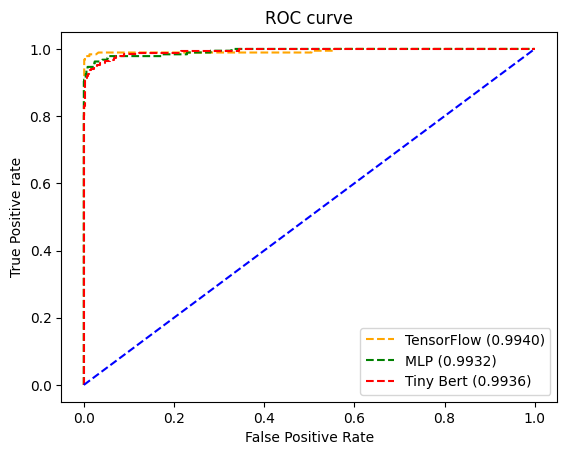

In [29]:
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='TensorFlow')
plt.plot(fpr2, tpr2, linestyle='--',color='green', label='MLP')
plt.plot(fpr3, tpr3, linestyle='--',color='red', label='Tiny Bert')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')

plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(['TensorFlow ({:.4f})'.format(auc_score1),
            'MLP ({:.4f})'.format(auc_score2),
            'Tiny Bert ({:.4f})'.format(auc_score3)])
plt.show()